[Link to the GitHub repo](https://github.com/peterpaullake/feature-visualization)
# Feature visualization for a CNN that classifies spectrograms of spoken digits

In this notebook, I:
- define a CNN for classifying spectrograms of spoken digits
- create an instance of the CNN and set its parameters to the parameters stored in `model.pt`, a file generated by `audio_classifier_cnn.py`
- use gradient ascent to find inputs that strongly activate three different channels in the model.

The model is trained on [Free Spoken Digit Dataset (FSDD)](https://github.com/Jakobovski/free-spoken-digit-dataset), a dataset of audio clips of spoken digits.
The `audio_classifier_cnn.py` file is used to generate the spectrograms from FSDD and to train the model.
All of the code in `audio_classifier_cnn.py` and in this notebook is my own.

In [58]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

### Define the `Model` class and load the trained model

In [59]:
class Model(nn.Module):
    """CNN for classifying spectrograms of spoken digits."""
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 5, kernel_size=8)
        self.conv2 = nn.Conv2d(5, 10, kernel_size=8)
        self.conv3 = nn.Conv2d(10, 10, kernel_size=3)
        self.fc1 = nn.Linear(51200, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, batch, conv_id=None, channel_id=0):
        """If conv_id is None, return the output of the
        model normally. Otherwise, return the mean of the
        channel specified by conv_id and channel_id."""
        def get_layer_mean(x):
            num_filters = x.shape[1]
            img_size = x.shape[2] * x.shape[3]
            means = x.view(-1, num_filters, img_size).mean(dim=2)
            return means[0][channel_id]
        
        out = batch.view(-1, 1, *batch.shape[-2:])
        
        out = self.conv1(out)
        out = F.max_pool2d(out, kernel_size=4)
        out = F.relu(out)
        if conv_id == 0:
            return get_layer_mean(out)

        out = self.conv2(out)
        out = F.max_pool2d(out, kernel_size=3)
        out = F.relu(out)
        if conv_id == 1:
            return get_layer_mean(out)

        out = self.conv3(out)
        out = F.max_pool2d(out, kernel_size=2)
        out = F.relu(out)
        if conv_id == 2:
            return get_layer_mean(out)

        out = out.view(-1, 51200)
        out = self.fc1(out)
        out = F.relu(out)
        out = F.dropout(out, training=self.training)

        out = self.fc2(out)
        return out

model = Model()
model.load_state_dict(torch.load('model.pt'))
model.eval()

Model(
  (conv1): Conv2d(1, 5, kernel_size=(8, 8), stride=(1, 1))
  (conv2): Conv2d(5, 10, kernel_size=(8, 8), stride=(1, 1))
  (conv3): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=51200, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

### Load the test set and display the first few examples

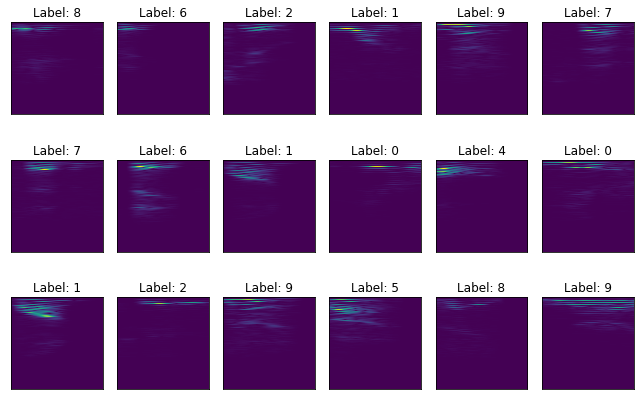

In [60]:
class Dataset(torch.utils.data.Dataset):
    """This class loads in the spectrogram files
    generated by audio_classifier_cnn.py."""
    def __init__(self, ids, labels):
        self.ids = ids
        self.labels = labels

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, index):
        i = self.ids[index]
        x = torch.load('data/%d.pt' % i)
        y = self.labels[i]
        return x, y
    
test = Dataset(torch.load('partition.pt')['test'], torch.load('labels.pt'))
fig, axs = plt.subplots(nrows=3, ncols=6, figsize=(9, 6),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in zip(range(len(axs.flat)), axs.flat):
    img = test[i][0][:500,:500]
    ax.imshow(img)
    ax.set_title('Label: %d' % test[i][1])

plt.tight_layout()

### Get the accuracy of the model on the test set

In [63]:
def compute_accuracy(model, dataset, batch_size=4):
    s = 0
    n = 0
    generator = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
    for batch, labels in generator:
        y = F.softmax(model(batch), dim=1).max(dim=1).indices.detach().numpy()
        correctness = (y == np.array(labels))
        s += correctness.sum()
        n += len(correctness)
    return s / n

compute_accuracy(model, test)

0.895

### Maximize (separately) the activations of three channels in the model
Total variation is used as a regularizer as a way to reduce noise.

In [64]:
def compute_total_variation(t):
    """Compute the total variation of an image:
    https://en.wikipedia.org/wiki/Total_variation_denoising#2D_signal_images"""
    return (t[1:,:] - t[:-1,:]).abs().sum() + (t[:,1:] - t[:,:-1]).abs().sum()

class Activation(nn.Module):
    """This class stores an input to the spoken digit spectrogram
    classifier. Feature visualization is done by adjusting self.weights
    to maximize the activation of a particular part of the model given
    as an argument to the forward method."""
    def __init__(self, conv_id=0, channel_id=0):
        super(Activation, self).__init__()
        self.weights = torch.nn.Parameter(data=torch.randn(1025, 3146))
        self.conv_id = conv_id
        self.channel_id = channel_id

    def forward(self, model, use_reg=False):
        # don't allow the spectrogram to be negative
        self.weights.data = F.relu(self.weights.data)
        out = torch.unsqueeze(self.weights, dim=0)
        # return the activation of the channel we are interested in studying
        out = model(out, self.conv_id, self.channel_id)
        if use_reg:
            # penalize the total variation of the
            # spectrogram to discourage noisy results
            return out - 0.000002 * compute_total_variation(self.weights)
        else:
            return out

def lmap(*args):
    return list(map(*args))

def maximize_activations(model, conv_ids, channel_ids, max_iters=1000, current_activations=None):
    """Maximize the activations of the channels specified by conv_ids and channel_ids."""
    activations = [] if current_activations is None else current_activations
    optimizers = []
    for i, conv_id, channel_id in zip(range(len(conv_ids)), conv_ids, channel_ids):
        if current_activations is None:
            activations.append(Activation(conv_id, channel_id))
        else:
            activations[i].train()
        optimizers.append(torch.optim.Adam(activations[i].parameters()))
    for i in range(max_iters):
        a_list = lmap(lambda activation : activation(model, use_reg=True), activations)
        losses = lmap(lambda a : -a, a_list)
        for optimizer, loss in zip(optimizers, losses):
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if i % 100 == 0:
            a_list = lmap(lambda activation : activation(model), activations)
            progress = (i + 1) / max_iters * 100
            print('\tmin activation: %.3f' % min(a_list))
            print('\tmax activation: %.3f' % max(a_list))
            print('\tprogress:       %.3f%%' % progress)
    for activation in activations:
        activation.eval()
    return activations

In [65]:
def copy_activations(activations, conv_ids, channel_ids):
    """Create copies of a list of Activation instances."""
    new_activations = []
    for activation, conv_id, channel_id in zip(activations, conv_ids, channel_ids):
        new_activation = Activation(conv_id, channel_id)
        new_activation.load_state_dict(activation.state_dict())
        new_activations.append(new_activation)
    return new_activations

conv_ids = [0, 1, 2]
channel_ids = [4, 6, 7]
activations0 = maximize_activations(model, conv_ids, channel_ids)

activations1 = copy_activations(activations0, conv_ids, channel_ids)
activations1 = maximize_activations(model, conv_ids, channel_ids, 500, activations1)

activations2 = copy_activations(activations1, conv_ids, channel_ids)
activations2 = maximize_activations(model, conv_ids, channel_ids, 500, activations2)

	min activation: 0.065
	max activation: 1.973
	progress:       0.100%
	min activation: 0.622
	max activation: 1.981
	progress:       10.100%
	min activation: 1.321
	max activation: 1.995
	progress:       20.100%
	min activation: 1.825
	max activation: 2.253
	progress:       30.100%
	min activation: 2.039
	max activation: 2.890
	progress:       40.100%
	min activation: 2.070
	max activation: 3.678
	progress:       50.100%
	min activation: 2.109
	max activation: 4.405
	progress:       60.100%
	min activation: 2.153
	max activation: 5.000
	progress:       70.100%
	min activation: 2.203
	max activation: 5.485
	progress:       80.100%
	min activation: 2.257
	max activation: 5.887
	progress:       90.100%
	min activation: 2.315
	max activation: 6.225
	progress:       0.200%
	min activation: 2.403
	max activation: 6.515
	progress:       20.200%
	min activation: 2.488
	max activation: 6.777
	progress:       40.200%
	min activation: 2.571
	max activation: 7.016
	progress:       60.200%
	min act

### Show the optimized spectrograms and their corresponding channel activations

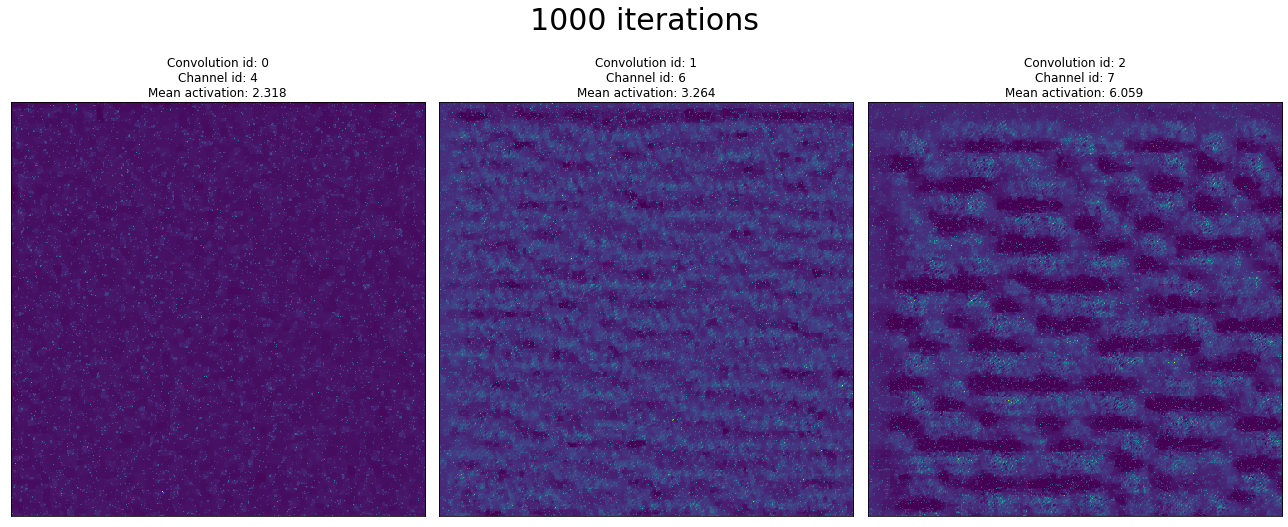

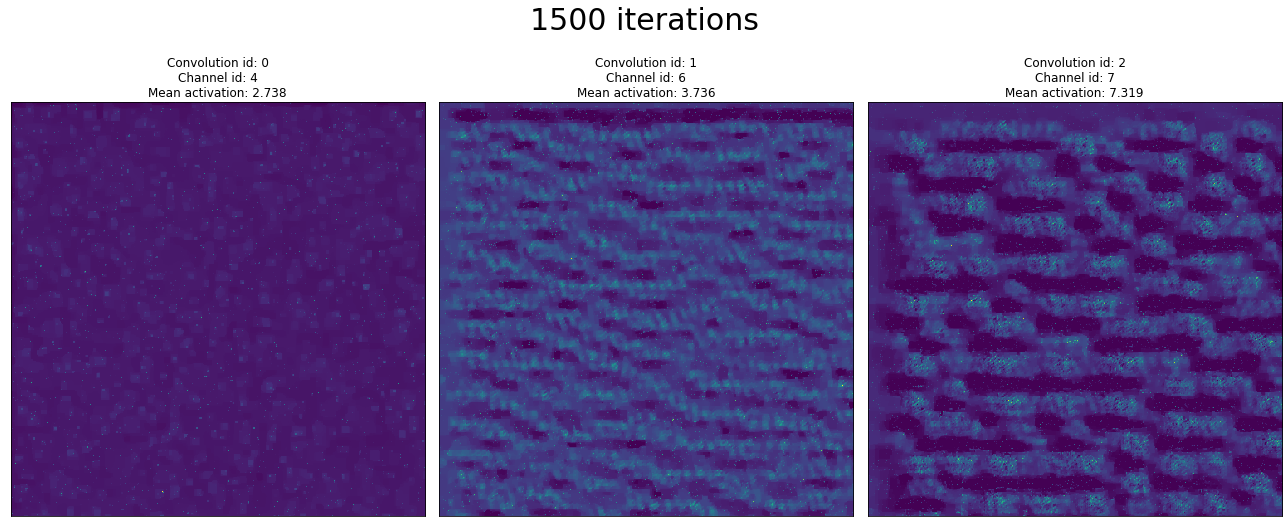

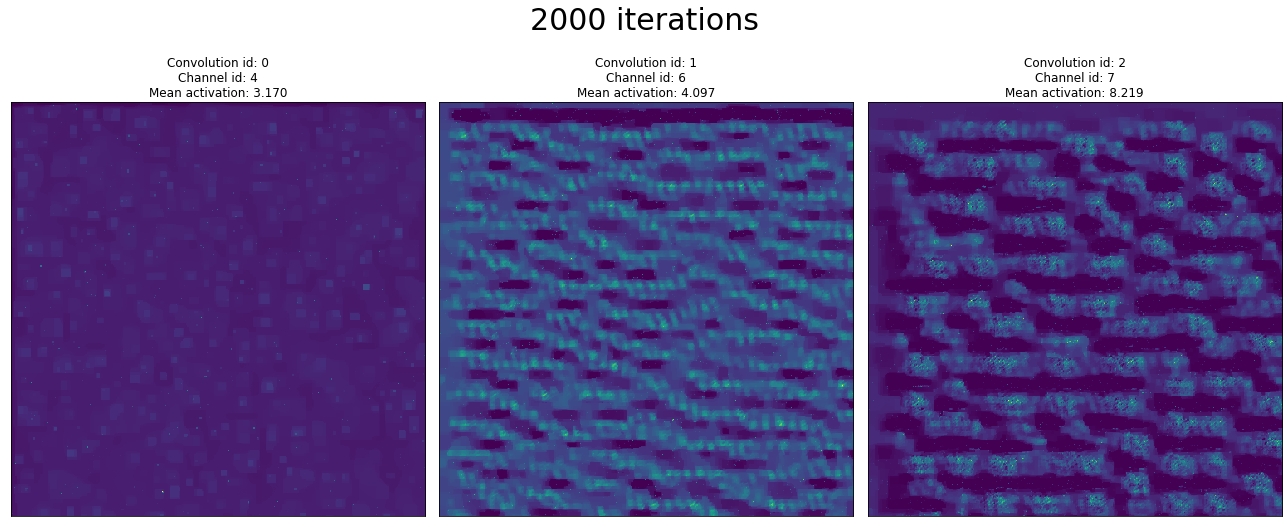

In [96]:
def show_activations(activations, conv_ids, channel_ids, title=''):
    fig, axs = plt.subplots(nrows=1, ncols=len(activations), figsize=(18, 12),
                            subplot_kw={'xticks': [], 'yticks': []})

    for i, ax, activation, conv_id, channel_id in zip(range(len(axs.flat)), axs.flat,
                                                      activations, conv_ids, channel_ids):
        img = activation.weights.data[:500,:500]
        ax.imshow(img)
        a = model(torch.unsqueeze(img, dim=0), conv_id, channel_id)
        ax.set_title('Convolution id: %d\nChannel id: %d\nMean activation: %.3f' % (conv_id, channel_id, a))

    fig.suptitle(title, fontsize=30, y=0.85)
    plt.tight_layout()
    
show_activations(activations0, conv_ids, channel_ids, '1000 iterations')
show_activations(activations1, conv_ids, channel_ids, '1500 iterations')
show_activations(activations2, conv_ids, channel_ids, '2000 iterations')

# Summary of results, interpretation, and remarks
The resulting spectrograms are visually interesting, but they are difficult to interpret and impossible to convert into audio because they have no phase information (see [plans for full implementation](#Plans-for-full-implementation) below).

The total variation regularizer for combating noise suggested by [Olah, et al.](https://distill.pub/2017/feature-visualization/) works well in this case. The results contain little noise while still retaining high-contrast features.

It was probably a mistake to choose such a large resolution for the spectrograms (1025 x 3146). This makes the dataset very large (about 25 GB) and the training and feature visualization slow and memory-consuming. The dataset size problem could probably have been alleviated by storing the spectrograms in a compressed format and decompressing them as they are read from the disk during training.

# Plans for full implementation
The full implementation will do feature visualization for a model that takes raw audio as input. This way, the result of doing feature visualization will be an audio clip instead of a spectrogram. Because a spectrogram has no phase information, it can't be converted into a listenable audio clip, which limits the interpretability of the feature visualization results.

Doing sample-level audio classification with neural networks has been done before with good results, for example in [this paper](https://arxiv.org/pdf/1712.00866.pdf).

It would be more interesting to do feature visualization on a model that solves a harder problem than spoken digit classification, and it would be helpful to train the model on a larger dataset. [Free Spoken Digit Dataset (FSDD)](https://github.com/Jakobovski/free-spoken-digit-dataset), the dataset used to train the model used in this notebook, has only 2500 examples. Creating a classification model using [Google's AudioSet dataset](https://research.google.com/audioset/index.html), a large dataset with many more classes, seems like a good next step.